In [49]:
import copy
import cv2
import numpy as np
import os

import torch
from torch.autograd import Variable
from torchvision import models
from torch import nn
from IPython.display import Image, display

## Adversarial Examples Homework

(Do not be intimidated by the large chunks of code, you do not need to understand all of it to do the homework. As long as you understand how adversarial examples work, to fill in the homework you just need to understand what the comment above the FILL_IN is about)

In this assignment, you will learn about adversarial examples. Adversarial examples are deliberately created inputs that fool a neural network. For example, in the picture below, by adding noise to an image of a panda that is correctly classified as a panda, we can fool a neural network into thinking it is a gibbon.

![](./images/panda.png)

Clearly, this has very dangerous consequences, especially considering how prevalent computer vision classification systems are. For example, in the image below physical stickers have been strategically placed on a stop sign that tricks a self-driving car into thinking it is a different traffic sign.

![](./images/stop_sign.png)

Run the cell below, it contains helper functions that will be used. You do not need to understand the details

In [50]:
def preprocess_image(cv2im, resize_im=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (Pytorch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        cv2im = cv2.resize(cv2im, (224, 224))
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing

    Args:
        im_as_var (torch variable): Image to recreate

    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    # Convert RBG to GBR
    recreated_im = recreated_im[..., ::-1]
    return recreated_im


def get_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.

    Args:
        example_index (int): Image id to use from examples

    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = [['./input_images/apple.JPEG', 948],
                    ['./input_images/eel.JPEG', 390],
                    ['./input_images/bird.JPEG', 13]]
    selected_example = example_index
    img_path = example_list[selected_example][0]
    target_class = example_list[selected_example][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = cv2.imread(img_path, 1)
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    pretrained_model = models.alexnet(pretrained=True)
    return (img_path, original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)

Today we will explore the Fast Gradient Sign Method (FGSM) of generating adversarial examples. You can find the paper that introduces it at this link if you are interested in reading more about it: https://arxiv.org/abs/1412.6572

The idea behind this method is in a sense the reversal of backpropagation. This is because we want to calculate the gradient of the cost (same as backprop so far) with respect to the input image pixels (different since with respect to model weights for backprop). In a sense, we want to know how perturbing each pixel will affect the cost, which will in turn affect what label the machine learning model classifies an image as. Once we know this, we know exactly how to exploit and perturb the image the minimal amount in order to get the model to classify it as a different label. Mathematically, FGSM takes the gradient computed from the description above, and converts each number into either +1 or -1 depending on its sign. Then, it multiplies this by a very small epsilon value and adds it to the original image. This new resulting image will then be classified incorrectly by the model this attack was created against. Pretty terrifying how easy it is to fool these models, huh.

The loss function used in this attack is the cross entropy loss between what the model predicts, and the actual label used. To get the label the model predicts that the loss is run on, you will need to actually call the model on the input image. The result of this is what is used for the loss function described.

In [51]:
# Fast Gradient Sign Untargeted to Fill In 

class FastGradientSignUntargeted():
    """
        Fast gradient sign untargeted adversarial attack, minimizes the initial class activation
        with iterative grad sign updates
    """
    def __init__(self, model, alpha):
        self.model = model
        self.model.eval()
        # Movement multiplier per iteration
        self.alpha = alpha
        # Create the folder to export images if not exists
        if not os.path.exists('./generated'):
            os.makedirs('./generated')

    def generate(self, original_image, im_label):
        # image label as variable
        im_label_as_var = Variable(torch.from_numpy(np.asarray([im_label])))
        # Define loss functions
        ce_loss = nn.CrossEntropyLoss()
        # Process image
        processed_image = preprocess_image(original_image)
        # Start iteration
        for i in range(10):
            print('Iteration:', str(i))
            # zero_gradients(x)
            # Zero out previous gradients
            # Can also use zero_gradients(x)
            processed_image.grad = None
            # Forward pass
            model_output = self.model(processed_image)
            # Calculate CE loss
            pred_loss = ce_loss(model_output, im_label_as_var)
            # Do backward pass
            pred_loss.backward()
            # Create Noise
            # Here, processed_image.grad.data is also the same thing is the backward gradient from
            # the first layer, can use that with hooks as well
            adv_noise = self.alpha * torch.sign(processed_image.grad.data)
            # Add Noise to processed image
            processed_image.data = processed_image + adv_noise

            # Confirming if the image is indeed adversarial with added noise
            # This is necessary (for some cases) because when we recreate image
            # the values become integers between 1 and 255 and sometimes the adversariality
            # is lost in the recreation process

            # Generate confirmation image
            recreated_image = recreate_image(processed_image)
            # Process confirmation image
            prep_confirmation_image = preprocess_image(recreated_image)
            # Forward pass to make sure creating the adversarial example was successful
            confirmation_out = self.model(prep_confirmation_image)
            # Get prediction
            _, confirmation_prediction = confirmation_out.data.max(1)
            # Get Probability
            confirmation_confidence = \
                nn.functional.softmax(confirmation_out)[0][confirmation_prediction].data.numpy()[0]
            # Convert tensor to int
            confirmation_prediction = confirmation_prediction.numpy()[0]
            # Check if the prediction is different than the original
            if confirmation_prediction != im_label:
                print('Original image was predicted as:', im_label,
                      'with adversarial noise converted to:', confirmation_prediction,
                      'and predicted with confidence of:', confirmation_confidence)
                # Create the image for noise, which is the difference between the
                # adversarial example and original image
                noise_image = confirmation_prediction - original_image
                name_noise = './generated/untargeted_adv_noise_from_' + str(im_label) + '_to_' + str(confirmation_prediction) + '.jpg'
                cv2.imwrite(name_noise, noise_image)
                # Write image
                name_image = './generated/untargeted_adv_img_from_' + str(im_label) + '_to_' + str(confirmation_prediction) + '.jpg'
                cv2.imwrite(name_image, recreated_image)
                
                
                return name_noise, name_image

        return 1

#### Test your implementation by running the below cell and visualizing. The first image is the original input image, second image is the noise added, and third is the adversarially perturbed image.

Iteration: 0
Original image was predicted as: 13 with adversarial noise converted to: 19 and predicted with confidence of: 0.96890265


/Users/gautam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


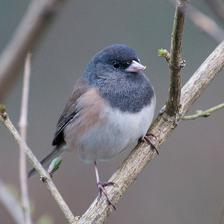

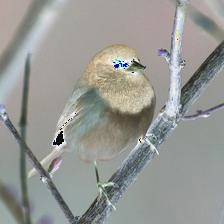

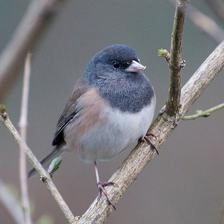

In [52]:
target_example = 2
(img_path, original_image, prep_img, target_class, _, pretrained_model) =\
    get_params(target_example)

FGS_untargeted = FastGradientSignUntargeted(pretrained_model, 0.01)
name_noise, name_image = FGS_untargeted.generate(original_image, target_class)

original = Image(img_path)
noise = Image(name_noise)
adversarial = Image(name_image)

display(original, noise, adversarial)

What you did above was an untargeted FGSM, so what it did was make a small change to fool the classifier into thinking the image was labeled with any other label than the one it actually is. On the other hand, ~targeted~ FGSM is where the adversarial image that is created is of a very deliberate, specific label. Besides that, the same techniques are applied. Read through the code below and fill in the 5 blank spots with very similar code to what you filled in above.

In [53]:
class FastGradientSignTargeted():
    """
        Fast gradient sign untargeted adversarial attack, maximizes the target class activation
        with iterative grad sign updates
    """
    def __init__(self, model, alpha):
        self.model = model
        self.model.eval()
        # Movement multiplier per iteration
        self.alpha = alpha
        # Create the folder to export images if not exists
        if not os.path.exists('./generated'):
            os.makedirs('./generated')

    def generate(self, original_image, org_class, target_class):
        # I honestly dont know a better way to create a variable with specific value
        # Targeting the specific class
        im_label_as_var = Variable(torch.from_numpy(np.asarray([target_class])))
        # Define loss functions
        ce_loss = nn.CrossEntropyLoss()
        # Process image
        processed_image = preprocess_image(original_image)
        # Start iteration
        for i in range(100):
            print('Iteration:', str(i))
            # zero_gradients(x)
            # Zero out previous gradients
            # Can also use zero_gradients(x)
            processed_image.grad = None
            # Forward pass
            model_output = self.model(processed_image)
            # Calculate CE loss
            pred_loss = ce_loss(model_output, im_label_as_var)
            # Do backward pass
            pred_loss.backward()
            # Create Noise
            # Here, processed_image.grad.data is also the same thing is the backward gradient from
            # the first layer, can use that with hooks as well
            adv_noise = self.alpha * torch.sign(processed_image.grad.data)
            # Subtract noise to processed image
            processed_image.data = processed_image - adv_noise

            # Confirming if the image is indeed adversarial with added noise
            # This is necessary (for some cases) because when we recreate image
            # the values become integers between 1 and 255 and sometimes the adversariality
            # is lost in the recreation process

            # Generate confirmation image
            recreated_image = recreate_image(processed_image)
            # Process confirmation image
            prep_confirmation_image = preprocess_image(recreated_image)
            # Forward pass
            confirmation_out = self.model(prep_confirmation_image)
            # Get prediction
            _, confirmation_prediction = confirmation_out.data.max(1)
            # Get Probability
            confirmation_confidence = \
                nn.functional.softmax(confirmation_out)[0][confirmation_prediction].data.numpy()[0]
            # Convert tensor to int
            confirmation_prediction = confirmation_prediction.numpy()[0]
            # Check if the prediction is different than the original
            if confirmation_prediction == target_class:
                print('Original image was predicted as:', org_class,
                      'with adversarial noise converted to:', confirmation_prediction,
                      'and predicted with confidence of:', confirmation_confidence)
                # Create the image for noise as: Original image - generated image
                noise_image = confirmation_prediction - original_image
                name_noise = './generated/targeted_adv_noise_from_' + str(org_class) + '_to_' + str(confirmation_prediction) + '.jpg'
                cv2.imwrite(name_noise, noise_image)
                # Write image
                name_image = './generated/targeted_adv_img_from_' + str(org_class) + '_to_' + str(confirmation_prediction) + '.jpg'
                cv2.imwrite(name_image, recreated_image)
                return name_noise, name_image
                break

        return 1

Iteration: 0


/Users/gautam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Original image was predicted as: 390 with adversarial noise converted to: 62 and predicted with confidence of: 0.27861667


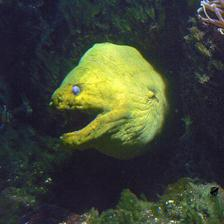

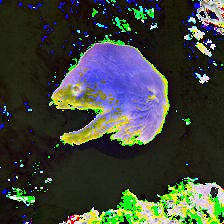

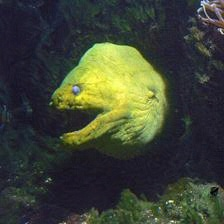

In [54]:
target_example = 1  # Apple
(img_path, original_image, prep_img, org_class, _, pretrained_model) =\
    get_params(target_example)
target_class = 62  # Mud turtle

FGS_untargeted = FastGradientSignTargeted(pretrained_model, 0.01)
name_noise, name_image = FGS_untargeted.generate(original_image, org_class, target_class)

original = Image(img_path)
noise = Image(name_noise)
adversarial = Image(name_image)

display(original, noise, adversarial)